### Background knowledge requirements

Required:
- Basic arithmetics
- Knowledge of matrix and vector multiplications
- Very basic knowledge of eigenvalues and eigenvectors

Desired:
- Numpy-Python

In [1]:
from qiskit import BasicAer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Combinatorial Optimizations with a gated Quantum Computer

#### Introduction
Given the task to maximize $C = \sum_{k = 1}^{m} C_k(z)$, where $z$ is a bit-string $z = z_1z_2...z_n$ and $z_i \in \{0, 1\}$ and each $C_k \in {0, 1}$.

---

Example with $n = 3$ and $m = 1$: Let the cost function be

$
C(z) = \begin{cases}
1 &\text{if } z_2 = 0 \wedge z_3 = 1\\
0 & \text{otherwise}
\end{cases}
$

In order to maximize $C$ one should find bit-strings $z = 001$ or $z = 101$. Eventually, in worst-case scenario, this will amount to eight iterations starting from $000$ to $111$.

---

There are $2^n$ combinations of $z$ to be considered when maximizing $C$. The number of combinations is also equal to the number of iterations that one needs to perform in order to retrieve the maximum of $C$. During each iteration a single combination is used to calculate the cost and afterwards a maximum is attained by finding the maximum element. 

By using the quantum mechanical principle of superposition all combinations may be regarded simultaneously. This principle inspired an optimization algorithm for gated quantum computers.

### Cost function in Quantum Mechanics

The cost function $C$ can be regarded as an operator (a unitary matrix) acting on a state $|z>$ (vector). 

#### Single discrete states and superposition
Instead of performing the operator $C$ on a single (discrete) state $|z>$, it is wiser to use the operator $C$ on a linear combination of multiple or all states. This new state is an arbitrary state in superposition and is referred to as the wavefunction $|\psi>$ This wavefunction is a sum of all $z$-states with coefficients $a_z$ in front of each $z$-state.

$ |\psi> = \sum_z a_z |z> $ where $ \sum_z |a_z| ^ 2 = 1 $

The coefficients $a_z$ are required to meet $l_2$-normalizations.

#### The (expectation) value of $C$

Starting with the single discrete states. 

$$ C |z> = \sum_{k = 1}^{m} C_k(z) |z> = f(z) |z> $$

Here, $f(z)$ denotes the eigenvalues of $C$. An eigen set with values and vectors is then retrieved: 
$ \text{eigenset} = \{f(z), z \in \{0, 1\}^n\} $
The largest eigenvalue and its corresponding eigenvector, $f(z')$ and $ |z'>$, gives the largest $C$ labelled $C_{max}$.

For a given $|z_k>$ the cost function's expectation value is calculated by:

$$ <C_{z_k}> \; = \; <z_k|C|z_k> $$

On the right-hand side first $C|z_k>$ is calculated where $C$ is a matrix and $|z_k>$ is a vector. This gives us a new vector. The new vector is then multiplied with the conjugate transpose of $|z_k>$, which is denoted as $<z_k|$. A scalar is retrieved being the expectation value of the cost function for that given state.

Generalizing the expectation value by using an arbitrary wavefunction yields:
$$ <C> \;=\; <\psi | C | \psi > $$

The expectation value for a given wavefunction is always equal or larger than the largest eigenvalue, since the largest eigenvalue is an element of the eigenset. 

$$ <C> \;=\; <\psi | C | \psi > \;=\; \sum_z f(z) |a_z|^2 \\
\leq \sum_z f(z') |a_z|^2 = f(z') \sum_z |a_z|^2 = f(z') $$

Thus, $<C>_{max}$ is only obtained when $<C>_{max} = f(z')$, which happens under the condition $|\psi> = |z'>$.

In reality the probability of finding $|z'>$ is $|a_{z'}|^2$ that is not necessarily one. Therefore, one gets close to $<C>_{max}$, hence the term _approximate_ within Quantum Approximate Optimization Algorithm. 

_Please keep in mind that the bra <.| is not actually meant to be the conjugate transpose of the ket |.>. Practically it is safe to use it that way._

#### The goal of QAOA

Start with an arbitrary wavefunction $|\psi>$ and calculate the cost function. Adjust $|\psi>$ iteratively until it is close to $|z'>$ and therefore close to the maximum cost.

### The Fundamentals of QAOA

Rotating the arbitrary state $|\psi>$ on quantum computers can be done by implementing quantum gates. A rotation may be comprised of a state change or a phase change. A state change, or also called a bit change, could for example change a $|0>$ into a $|1>$. A phase change might induce a change in amplitudes without changing the probability distribution, e.g. (notice the plus and minus signs) 

$\frac{1}{\sqrt{2}}|0> + \frac{1}{\sqrt{2}}|1> \;\longrightarrow \;\frac{1}{\sqrt{2}}|0> - \frac{1}{\sqrt{2}}|1>$.  

Two different abstract quantum gates will be used to induce phase and state changes. Both gates are Hermitian and have parameters $\gamma$ and $\beta$ that account for the phase and state changes respectively. The parameters will be discussed in more detail later on, but it is wise to give a preliminary view on these parameters. This is done by using the circuit below as an example.

The circuit starts off with an arbitrary state $|\psi>$ with qubits $|a>, |b>, |c>$. At first the $U(C, \gamma)$ is applied to the circuit. This is called the cost function gate and this abstract gate contains all the information on the cost function. The $\gamma$-parameter induces phase changes. The second gate, $U(B, \beta)$ is called the mixing gate and performs state changes. The degree of state changes is dependent on the parameter $\beta$. The phase and state changes account for traversing the hyper-dimensional complex solution space in which the optimal solution is available (hopefully). 

<img src="qaoabasic.png" width=750 height=480 />


#### Phase Change by $U(C,\gamma)$

This unitary quantum gate has two parameters, $C$ and $\gamma$, which correspond to the cost function matrix and a phase shift respectively. The phase change quantum gate is defined as $U(C, \gamma) = e^{-i\gamma C}$.

$$ U(C, \gamma) = e^{-i\gamma C} = e^{-i\gamma \sum_{k=1}^{m}C_k} = \prod_{k=1}^{m} e^{-i\gamma C_k}$$

Given that $ |\psi> = \sum_z a_z |z> $, applying $U(C, \gamma)$ to $|\psi>$ results in

$$ U(C, \gamma)|\psi> = \sum_z \prod_{k=1}^{m} U(C_k(z), \gamma) a_z |z> $$

Since $C_k(z)$ can only be $0$ or $1$ as mentioned in the introduction, the phase change gate results in:

$
U(C_k(z), \gamma) = \begin{cases}
1 &\text{if } C_k(z) = 0\\
e^{-i \gamma} & \text{if } C_k(z) = 1
\end{cases}
$

A phase change is induced when $C_k(z)$ is 1 or otherwise nothing changes. This is quite similar to controlled quantum gates. The control qubit checks if $C_k(z) = 1$ and, if satisfied, conducts a phase change $e^{-i \gamma}$ on a target qubit (an auxilary/ancilla qubit mostly). Luckily, there is an existing quantum gate that mimicks this phase change, namely the R$(\gamma)$-gate.

$$ R(\gamma) = \begin{bmatrix} 1 & 0 \\ 0 & e^{-i \gamma} \end{bmatrix} $$

---

**Example of the Phase Change Gate**

In a 2 qubit system $|\psi> = |x_1>|x_2>$ with the following cost functions:

$ C_1 = 1 \text{ if } |x_1> = |1> $

$ C_2 = 1 \text{ if } |x_1> = |1> \text{ and } |x_2> = |1> $

Classically, a truth table may show that the cost function is maximized by the state $|1>|1>$.

| $x_1$ | $x_2$ | $C_1$ | $C_2$ | $ C = C_1 + C_2 $ |
| ------| ----- | ----- | ----- | ----------------- |
| $0$   |  $0$  |  $0$  |  $0$  |       $0$         |
| $0$   |  $1$  |  $0$  |  $0$  |       $0$         |
| $1$   |  $0$  |  $1$  |  $0$  |       $1$         |
| $1$   |  $1$  |  $1$  |  $1$  |       $2$         |


Each qubit can be written in an arbitrary state:

$ |x_1> = a_0|0> + a_1|1> $

$ |x_2> = b_0|0> + b_1|1> $

Then the arbitrary wave function becomes:

$ |\psi> = a_0b_0|00> + a_0b_1|01> + a_1b_0|10> + a_1b_1|11> $

Then applying $U(C, \gamma)$ gives:

$ U(C, \gamma)|\psi> = a_0b_0|00> + a_0b_1|01> + a_1b_0 R(\gamma)|10> + a_1b_1R(\gamma)^2|11> $

Notice the prefactors at $|10>$ and $|11>$. At the latter state the R$(\gamma)$-gate is applied twice because this state satisfied both cost functions.

All that we need is a Controlled-R$(\gamma)$-gate.

<img src="ucy.png" width=450 height=300 />

#### State Change by $U(B, \beta)$

This unitary quantum gates has two arguments, $B$ and $\beta$, where $B$ is defined as $B = \sum_{j=1}^{n} \sigma_j^x$. Here, $\sigma_j^x$ is an $X$-gate on the $j$'th register. But that will not be exactly relevant, since the state change gate has the B in its exponent as the definition is $ U(B, \beta) = e^{-i\beta B} $. This in turn can be written as

$$ U(B, \beta) = e^{-i\beta B} = e^{-i\beta \sum_{j=1}^{n} \sigma_j^x} = \prod_{j=1}^{n} e^{-i\beta \sigma_j^x} $$

The right-hand side tells that a gate matching $ U(B_j, \beta) = e^{-i\beta \sigma_j^x} $ should be applied to every register. Looking up at the Circuit-Library one finds a match:

$$ R_x(\theta) = e^{-i \frac{\theta}{2}\sigma^x} \Longrightarrow U(B_j, \beta) = R_x(2\beta)\$$

This comes down to putting an $R_x(2\beta)$ gate everywhere.


<img src="ubb.png" width=300 height=200 />

#### Creating a QAOA circuit from the example

Then all that is left is to merge $U(C, \gamma)$ and $U(B, \beta)$ into a single circuit.

<img src="singleiteration.png" width=450 height=300 />

Upon measuring the quantum circuit the probability distribution is used to calculate the cost function. The classical approach will be mentioned in a concrete example rather than to have a general discussion about it.

### Optimizing $\beta$ and $\gamma$

With only two parameters $\beta$ and $\gamma$ the accuracy of optimization might be low or undesirable. By using multiple iterations of $U(C, \gamma)$ and $U(B, \beta)$ the accuracy goes up. An example below shows a circuit with $p$ iterations of the unitary phase and state changing gates.

<img src="iterative.png" width=600 height=300 />

If there are $p$ iterations of $U(C, \gamma)$ and $U(B, \beta)$, then $2p$ parameters need to be optimized. Therefore, one needs to optimize $(\vec{\gamma}, \vec{\beta})$ where $\vec{\gamma} = \begin{bmatrix} \gamma_1 & \gamma_2 & ... & \gamma_p \end{bmatrix}^T$ and $\vec{\beta} = \begin{bmatrix} \beta_1 & \beta_2 & ... & \beta_p \end{bmatrix}^T$

Optimizing these parameters is done by classical optimizers, for example, by COBYLA. In this Jupyter Notebook the classical optimizers are not discussed. It is better to see it happen in real-life and to adjust the type of optimizers for the specific problem that one encounters.

Upon performing the measurements a probability distribution is obtained. The probability distribution is then used to calculated an expectation value of the cost function by $<C> = <\psi|C|\psi>$. In the number partitioning example a concrete implementation of this process will be highlighted. 

## Number Partitioning and QAOA

### Cost function of Number Partitioning

The example used for number partitioning may be found in the previous Jupyter-Notebooks on Number Partitioning. A set $S = \{1, 3, 4\}$ needs to be partitioned into two subsets of which the sums of elements are equivalent. The answer should be $S_1 = \{1, 3\}$ and $S_2 = \{4\}$ or its degenerate counterpart $S_1 = \{4\}$ and $S_2 = \{1, 3\}$.

In the previous Jupyter-Notebook an Ising model of the Number Partitioning problem was derived, which was:

$$ \hat{C} = 6\sigma_1^z\sigma_2^z + 8\sigma_1^z\sigma_3^z + 24 \sigma_2^z\sigma_3^z $$

This problem has only three quadratic terms, which can written as a dictionary.

_Typically in code an array starts with index 0. To avoid confusion the indices of the equations are followed. Later in the code adjustments will be done and within the code there will be comments specifically dedicated to this._

In [2]:
# The Ising Model
j = dict()
j[(1, 2)] = 6
j[(1, 3)] = 8
j[(2, 3)] = 24

For this simple example the number of iterations of the U-gates is set to 5. This means that there are 10 parameters that need to be optimized. The parameters are initialized randomly. Two Numpy-arrays called _betas_ and _gammas_ are initialized. The parameters have bounds $(0, \pi)$. 

In this example a single array of parameters called _params_ is created by alternating each $\gamma$ and $\beta$ from _gammas_ and _betas_. That is:

_params_ = $\begin{bmatrix} \gamma_1 \\ \beta_1 \\ ... \\ \gamma_p \\ \beta_p \end{bmatrix}$


In [3]:
p = 5
betas = np.pi * np.random.rand(p)
gammas = np.pi * np.random.rand(p)

params = list()
for i in range(0, len(betas)):
    params.append(gammas[i])
    params.append(betas[i])
params = np.array(params)

It is not possible to construct a circuit out of the blue. At first, using $H$-gates initializes the quantum circuit and brings all qubits in a superposition. The gate $U(C, \gamma)$ is problem-specific. Luckily, $U(B, \beta)$ is a general gate. Therefore, $U(C, \gamma)$ should be first explicitly and thoroughly constructed. Starting off from its definition $U(C, \gamma) = e^{-i \gamma C}$ a circuit will be derived. The cost function $C$ has been mentioned in the introduction and is

$$ \hat{C} = 6\sigma_1^z\sigma_2^z + 8\sigma_1^z\sigma_3^z + 24 \sigma_2^z\sigma_3^z $$

$$ U(C, \gamma) = e^{-i \gamma C} = e^{-i \gamma (6\sigma_1^z\sigma_2^z + 8\sigma_1^z\sigma_3^z + 24 \sigma_2^z\sigma_3^z)} $$

Using Trotterization, i.e. $e^{-i\gamma \sum_{k=1}^{m}C_k} = \prod_{k=1}^{m} e^{-i\gamma C_k}$ the sum in the exponent is reduced to a product of exponents.

$$ U(C, \gamma) = e^{-i \gamma C} = e^{-i 6 \gamma\,\sigma_1^z\sigma_2^z} e^{-i 8 \gamma\,\sigma_1^z\sigma_3^z} e^{-i 24 \gamma\,\sigma_2^z\sigma_3^z} $$

Now there are three products of the form $e^{i \frac{\gamma}{2}\,\sigma_u^z\sigma_v^z}$.

There exists a (series of) quantum gate(s) for this specific form. It is important to take into account the division by $2$ and the minus-sign. The product $e^{i \frac{\gamma}{2}\,\sigma_u^z\sigma_v^z}$ is described by: 

<img src="circuitry.png" width=600 height=300 />

Implementing the superposition-initialization, the phase changing gate $U(C, \gamma)$ and the state changing gate $U(B, \beta)$ for a **single** iteration gives the following circuit.

<img src="qaoacirc.png" width=600 height=300 />

#### Creating a QAOA circuit from the example

Then all that is left is to merge $U(C, \gamma)$ and $U(B, \beta)$ into a single circuit.

<img src="singleiteration.png" width=450 height=300 />

Upon measuring the quantum circuit the probability distribution is used to calculate the cost function. The classical approach will be mentioned in a concrete example rather than to have a general discussion about it.

### Optimizing $\beta$ and $\gamma$

With only two parameters $\beta$ and $\gamma$ the accuracy of optimization might be low or undesirable. By using multiple iterations of $U(C, \gamma)$ and $U(B, \beta)$ the accuracy goes up. An example below shows a circuit with $p$ iterations of the unitary phase and state changing gates.

<img src="iterative.png" width=600 height=300 />

If there are $p$ iterations of $U(C, \gamma)$ and $U(B, \beta)$, then $2p$ parameters need to be optimized. Therefore, one needs to optimize $(\vec{\gamma}, \vec{\beta})$ where $\vec{\gamma} = \begin{bmatrix} \gamma_1 & \gamma_2 & ... & \gamma_p \end{bmatrix}^T$ and $\vec{\beta} = \begin{bmatrix} \beta_1 & \beta_2 & ... & \beta_p \end{bmatrix}^T$

Optimizing these parameters is done by classical optimizers, for example, by COBYLA. In this Jupyter Notebook the classical optimizers are not discussed. It is better to see it happen in real-life and to adjust the type of optimizers for the specific problem that one encounters.

Upon performing the measurements a probability distribution is obtained. The probability distribution is then used to calculated an expectation value of the cost function by $<C> = <\psi|C|\psi>$. In the number partitioning example a concrete implementation of this process will be highlighted. 

## Number Partitioning and QAOA

### Cost function of Number Partitioning

The example used for number partitioning may be found in the previous Jupyter-Notebooks on Number Partitioning. A set $S = \{1, 3, 4\}$ needs to be partitioned into two subsets of which the sums of elements are equivalent. The answer should be $S_1 = \{1, 3\}$ and $S_2 = \{4\}$ or its degenerate counterpart $S_1 = \{4\}$ and $S_2 = \{1, 3\}$.

In the previous Jupyter-Notebook an Ising model of the Number Partitioning problem was derived, which was:

$$ \hat{C} = 6\sigma_1^z\sigma_2^z + 8\sigma_1^z\sigma_3^z + 24 \sigma_2^z\sigma_3^z $$

This problem has only three quadratic terms, which can written as a dictionary.

_Typically in code an array starts with index 0. To avoid confusion the indices of the equations are followed. Later in the code adjustments will be done and within the code there will be comments specifically dedicated to this._

In [4]:
# The Ising Model
j = dict()
j[(1, 2)] = 6
j[(1, 3)] = 8
j[(2, 3)] = 24

For this simple example the number of iterations of the U-gates is set to 5. This means that there are 10 parameters that need to be optimized. The parameters are initialized randomly. Two Numpy-arrays called _betas_ and _gammas_ are initialized. The parameters have bounds $(0, \pi)$. 

In this example a single array of parameters called _params_ is created by alternating each $\gamma$ and $\beta$ from _gammas_ and _betas_. That is:

_params_ = $\begin{bmatrix} \gamma_1 \\ \beta_1 \\ ... \\ \gamma_p \\ \beta_p \end{bmatrix}$


In [5]:
p = 5
betas = np.pi * np.random.rand(p)
gammas = np.pi * np.random.rand(p)

params = list()
for i in range(0, len(betas)):
    params.append(gammas[i])
    params.append(betas[i])
params = np.array(params)
initial_params = params

It is not possible to construct a circuit out of the blue. At first, using $H$-gates initializes the quantum circuit and brings all qubits in a superposition. The gate $U(C, \gamma)$ is problem-specific. Luckily, $U(B, \beta)$ is a general gate. Therefore, $U(C, \gamma)$ should be first explicitly and thoroughly constructed. Starting off from its definition $U(C, \gamma) = e^{-i \gamma C}$ a circuit will be derived. The cost function $C$ has been mentioned in the introduction and is

$$ \hat{C} = 6\sigma_1^z\sigma_2^z + 8\sigma_1^z\sigma_3^z + 24 \sigma_2^z\sigma_3^z $$

$$ U(C, \gamma) = e^{-i \gamma C} = e^{-i \gamma (6\sigma_1^z\sigma_2^z + 8\sigma_1^z\sigma_3^z + 24 \sigma_2^z\sigma_3^z)} $$

Using Trotterization, i.e. $e^{-i\gamma \sum_{k=1}^{m}C_k} = \prod_{k=1}^{m} e^{-i\gamma C_k}$ the sum in the exponent is reduced to a product of exponents.

$$ U(C, \gamma) = e^{-i \gamma C} = e^{-i 6 \gamma\,\sigma_1^z\sigma_2^z} e^{-i 8 \gamma\,\sigma_1^z\sigma_3^z} e^{-i 24 \gamma\,\sigma_2^z\sigma_3^z} $$

Now there are three products of the form $e^{i \frac{\gamma}{2}\,\sigma_u^z\sigma_v^z}$.

There exists a (series of) quantum gate(s) for this specific form. It is important to take into account the division by $2$ and the minus-sign. The product $e^{i \frac{\gamma}{2}\,\sigma_u^z\sigma_v^z}$ is described by: 

<img src="circuitry.png" width=600 height=300 />

Implementing the superposition-initialization, the phase changing gate $U(C, \gamma)$ and the state changing gate $U(B, \beta)$ for a **single** iteration gives the following circuit.

<img src="qaoacirc.png" width=600 height=300 />

Now to construct the circuit in qiskit.

#### Qiskit Implementation
For this problem only three qubits are needed. Every qubit is measured eventually, therefore, three classical channels are required. Each time the classical optimization is called the whole circuit needs to be constructed again. Therefore, a method to construct the circuit is used here.

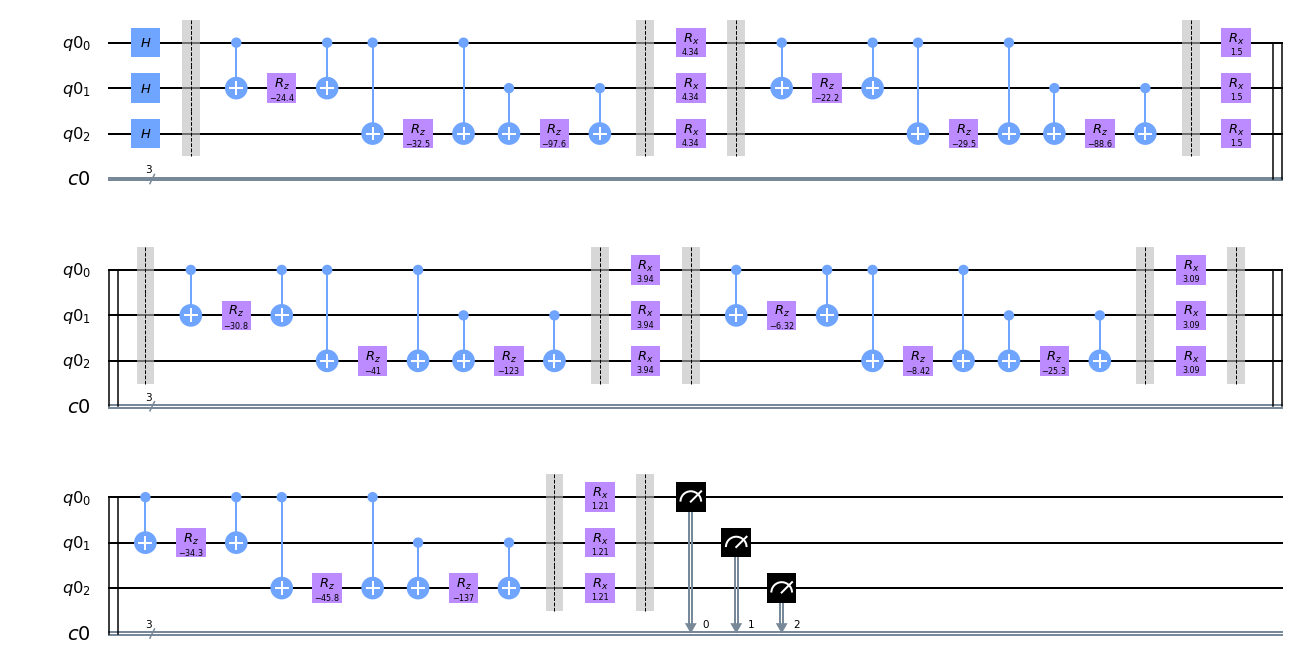

In [6]:
def qaoa_circuit(params):
    # Instantiating a Circuit
    n = 3
    q = QuantumRegister(3)
    c = ClassicalRegister(3)
    circ = QuantumCircuit(q, c)
    
    # Initializing the circuit by Hadamard-Gates
    for i in range(n):
        circ.h(q[i])
    
    circ.barrier()
    # Creating p times U(C, gamma) and U(B, beta)
    for i in range(p):
        # 6 * sigma_1 * sigma_2
        circ.cx(q[0], q[1])
        circ.rz(-12 * params[2 * i], 1)
        circ.cx(0, 1)
        
        # 8 * sigma_1 * sigma_3
        circ.cx(0, 2)
        circ.rz(-16 * params[2 * i], 2)
        circ.cx(0, 2)
        
        # 24 * sigma_1 * sigma_3
        circ.cx(1, 2)
        circ.rz(-48 * params[2 * i], 2)
        circ.cx(1, 2)
        
        circ.barrier()
        # sigma_x for U(B, beta)
        for j in range(n):
            circ.rx(2*params[2 * i + 1], q[j])
        circ.barrier()
    # Putting the measurement gates
    circ.measure(q, c)
    
    return circ

circ = qaoa_circuit(params)
circ.draw(output='mpl')

Now that the circuit has been constructed, a method to evaluate the results of the circuit needs to be built. Actually, only one method normally suffices for this problem. However, Qiskit never returns states with zero counts as a result in the form of a dictionary. The following two methods are meant to include zero counts states. The last method in the cell afterwards does the actual measuring work.

In [7]:
"""
These two methods include zero counts. One may skip them for now.
"""

from qiskit.ignis.verification.tomography import count_keys

def cut_counts(counts, bit_indexes):
    bit_indexes.sort(reverse=True)
    new_counts = {}
    for key in counts:
        new_key = ''
        for index in bit_indexes:
            new_key += key[-1 - index]
        if new_key in new_counts:
            new_counts[new_key] += counts[key]
        else:
            new_counts[new_key] = counts[key]

    return new_counts

def get_all_counts(counts: dict, number_of_qubits):
    all_counts = dict()
    keys = count_keys(number_of_qubits)
    for key in keys:
        if key in counts:
            all_counts[key] = counts[key]
        else:
            all_counts[key] = 0
    return all_counts

In [8]:
def circuit_results(circuit):
    # A simulator is used here instead of real hardware
    backend = BasicAer.get_backend('qasm_simulator')
    
    # The circuit is executed by the backend with 30000 shots per measurement
    shots=30000
    result = execute(circuit, backend=backend, shots=shots).result()
    
    # Getting and return results as a dictionary and as an output_distribution with all values between 0 and 1.
    counts = result.get_counts(circuit)
    all_counts = get_all_counts(counts, circuit.num_qubits)
    output_distribution = [v / shots for v in all_counts.values()]
    return all_counts, output_distribution

#### Coding the cost function


What is firstly needed is to create a cost function matrix from the cost function. 

$$ \hat{C} = 6\sigma_1^z\sigma_2^z + 8\sigma_1^z\sigma_3^z + 24 \sigma_2^z\sigma_3^z $$

The following matrix is expected.

$$ \hat{C} = \begin{bmatrix} 38 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & -26 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & -22 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 10 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 10 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & -22 & 0 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & -26 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 38 \end{bmatrix}$$

Defining the Pauli-Z matrix and the identity matrix, subsequently taking the tensor products provides the matrix.

In [9]:
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)

term1 = 6 * np.kron(Z, np.kron(Z, I))
term2 = 8 * np.kron(Z, np.kron(I, Z))
term3 = 24 * np.kron(I, np.kron(Z, Z))

C = term1 + term2 + term3

print(C)

[[ 38.   0.   0.   0.   0.   0.   0.   0.]
 [  0. -26.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -22.   0.   0.   0.   0.   0.]
 [  0.   0.   0.  10.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  10.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -22.   0.   0.]
 [  0.   0.   0.   0.   0.   0. -26.   0.]
 [  0.   0.   0.   0.   0.   0.   0.  38.]]


The following step is to define an objective function that will be the core of the optimization. In this case a minimization is desired of $<\psi|C|\psi>$. Here, $|\psi>$ is the _final state vector / output distribution_ of the circuit, hence, it is depending on $\vec{\gamma}$ and $\vec{\beta}$.

The objective function is:

$$ f(\vec{\gamma}, \vec{\beta}) = <\psi(\vec{\gamma}, \vec{\beta})|C|\psi(\vec{\gamma}, \vec{\beta})> $$

The following method defines the objective function.

In [10]:
def objective_function(params):
    # constructing the circuit, in this example, make sure circ already exists
    circ = qaoa_circuit(params)
    
    # retrieve the results of the quantum circuit
    output_distribution = circuit_results(circ)[1]
    
    # calculate the cost function by using the equation above
    cost = np.transpose(output_distribution) @ C @ output_distribution
    return cost

#### Calling the Optimizer

Here, COBYLA is used as it is a simple optimizer that gives quite accurate results. The COBYLA optimizer needs two parameters, maximum iterations and the tolerance. The initial parameters for the optimizations are _params_. One can choose to pose bounds on the _params_.

As part of visualizing that it works, a histogram will be plotted before and after the optimization.

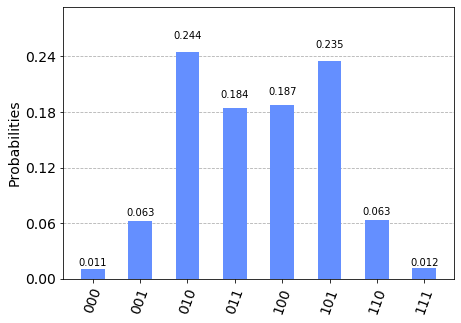

In [11]:
# Plotting the results without optimizing

before_optimizing = circuit_results(circ)[0]

plot_histogram(before_optimizing)

(array([2.03274746, 3.1322407 , 1.85321163, 0.74868941, 2.55574176,
       1.96431386, 0.51606492, 2.54385796, 2.85461843, 0.60097385]), -10.861309039999998, 76)


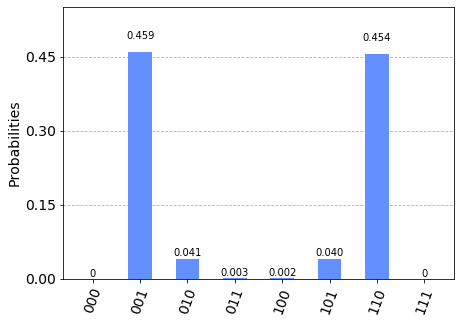

In [12]:
from qiskit.aqua.components.optimizers import COBYLA

# A COBYLA instance with 500 iterations max and a tolerance level of 0.001
optimizer = COBYLA(maxiter=500, tol=0.001)

# Performing the optimization
ret = optimizer.optimize(num_vars=len(params), objective_function=objective_function, initial_point=params)

# Printing the results
print(ret)

# Using the new parameters and constructing the new parameterized circuit
new_params = ret[0]
circ_after = qaoa_circuit(new_params)

# Getting the results of the optimized circuit
after_optimizing = circuit_results(circ_after)[0]

# Plotting the results of the optimized circuit
plot_histogram(after_optimizing)

The states $|001>$ and $|110>$ are the most optimal solutions now. As a reminder, labels '0' and '1' stand for subset $S_1$ and subset $S_2$ respectively. Solution $(0, 0, 1)$ means $(S_1, S_1, S_2)$ and using it on $\{1, 3, 4\}$ gives $S_1 = \{1, 3\}$ and $S_2 = \{4\}$. Likewise, $(1, 1, 0)$ gives $S_1 = \{4\}$ and $S_2 = \{1, 3\}$.

Thus, a successful implementation of Number Partitioning by QAOA.